In [ ]:
#Importing libraries
import gdown
import zipfile
import os
import shutil
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [ ]:
# Downloading zipped data from drive

file_id = "1rHKiveyklxUdu5WWCfAPMvbFiBmAgDuB"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "FinalData.zip", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1rHKiveyklxUdu5WWCfAPMvbFiBmAgDuB
From (redirected): https://drive.google.com/uc?id=1rHKiveyklxUdu5WWCfAPMvbFiBmAgDuB&confirm=t&uuid=1fece64a-2908-4ced-96a2-8a15820662bc
To: /content/FinalData.zip
100%|██████████| 403M/403M [00:03<00:00, 107MB/s]


'FinalData.zip'

In [ ]:
# Unzipping data

print("Unzipping...")
with zipfile.ZipFile("FinalData.zip", "r") as z:
    z.extractall("dataset")

print("Done!")


Unzipping...
Done!


In [ ]:

# ---------------- CONFIG ----------------
raw_folder = "dataset/FinalData"
cnn_base_folder = "dataset/cnn_ready_split"
img_formats = (".png", ".jpg", ".jpeg")
splits = {"train": 0.8, "val": 0.1, "test": 0.1}
payload_ratio = 0.5  # 50% of all LSBs will be embedded

# ---------------- CLEAN EXISTING CNN FOLDER ----------------
if os.path.exists(cnn_base_folder):
    shutil.rmtree(cnn_base_folder)

# ---------------- CREATE FOLDER STRUCTURE ----------------
for split in ["train", "val", "test"]:
    for cls in ["raw", "lsb"]:
        os.makedirs(os.path.join(cnn_base_folder, split, cls), exist_ok=True)


In [ ]:
# ---------------- LSB EMBEDDING FUNCTION ----------------
def embed_lsb(img_path, payload_ratio=0.5):

    img = Image.open(img_path)
    if img.mode != "RGB":
        img = img.convert("RGB")
    arr = np.array(img, dtype=np.uint8)
    flat_arr = arr.flatten()

    num_pixels = flat_arr.size
    num_bits_to_embed = int(num_pixels * payload_ratio)


    msg_bits = np.random.randint(0, 2, num_bits_to_embed)


    flat_arr[:num_bits_to_embed] = (flat_arr[:num_bits_to_embed] & 0xFE) | msg_bits

    new_arr = flat_arr.reshape(arr.shape)
    return Image.fromarray(new_arr)

In [ ]:

# ---------------- SPLIT AND COPY ----------------
imgs = [f for f in os.listdir(raw_folder) if f.lower().endswith(img_formats)]

train_imgs, temp_imgs = train_test_split(imgs, test_size=splits["val"] + splits["test"], random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=splits["test"] / (splits["val"] + splits["test"]), random_state=42)

split_dict = {"train": train_imgs, "val": val_imgs, "test": test_imgs}

for split_name, split_imgs in split_dict.items():
    for img_file in split_imgs:
        raw_path = os.path.join(raw_folder, img_file)

        # COPY RAW IMAGE
        shutil.copy(raw_path, os.path.join(cnn_base_folder, split_name, "raw", img_file))

        # CREATE LSB IMAGE
        lsb_img = embed_lsb(raw_path, payload_ratio=payload_ratio)
        lsb_img.save(os.path.join(cnn_base_folder, split_name, "lsb", img_file))

print(" Dataset prepared with train/val/test splits and LSB embedded (0.5 payload).")


 Dataset prepared with train/val/test splits and LSB embedded (0.5 payload).


In [ ]:
# ---------------- CONFIG ----------------
cnn_base_folder = "dataset/cnn_ready_split"
img_height, img_width = 224, 224
batch_size = 32
initial_epochs = 20
fine_tune_epochs = 30
model_save_path = "lsb_mobilenetv2_model.h5"
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# Loading and Splitting

train_ds = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(cnn_base_folder, "train"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42
)

val_ds = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(cnn_base_folder, "val"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_ds = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(cnn_base_folder, "test"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 18586 images belonging to 2 classes.
Found 2324 images belonging to 2 classes.
Found 2324 images belonging to 2 classes.


In [ ]:

# ---------------- BUILD MODEL ----------------
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model initially

inputs = Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #Initial learning rate 0.001

In [ ]:
# ---------------- TRAIN MODEL (INITIAL) ----------------

early_stop = EarlyStopping(
    monitor='val_loss',     # monitor validation loss
    patience=7,             # stop after 5 epochs of no improvement
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,      # divide lr by 10
    patience=7,      # wait 7 bad epochs
    min_lr=1e-7,     # do not go below 1 x 10^-7
    verbose=1
)


history = model.fit(
    train_ds,
    validation_data= val_ds,
    batch_size=32,
    epochs=initial_epochs,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 57s 83ms/step - accuracy: 0.5832 - loss: 0.7098 - val_accuracy: 0.7173 - val_loss: 0.5741 - learning_rate: 0.0010
Epoch 2/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 37s 63ms/step - accuracy: 0.6898 - loss: 0.5968 - val_accuracy: 0.7272 - val_loss: 0.5560 - learning_rate: 0.0010
Epoch 3/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 38s 66ms/step - accuracy: 0.7067 - loss: 0.5828 - val_accuracy: 0.7384 - val_loss: 0.5420 - learning_rate: 0.0010
Epoch 4/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 37s 64ms/step - accuracy: 0.7090 - loss: 0.5743 - val_accuracy: 0.7435 - val_loss: 0.5357 - learning_rate: 0.0010
Epoch 5/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 36s 62ms/step - accuracy: 0.7089 - loss: 0.5766 - val_accuracy: 0.7104 - val_loss: 0.5564 - learning_rate: 0.0010
Epoch 6/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 35s 61ms/step - accuracy: 0.7082 - loss: 0.5753 - val_accuracy: 0.7440 - val_loss: 0.5343 - learning_rate: 0.0010
Epoch 7/20
581/581 ━━━━━━━━━━━━━━━━━━━━ 37s 64ms/step - accuracy: 0.7155 - l

In [ ]:
# ---------------- FINE-TUNE ----------------
base_model.trainable = True
fine_tune_at = 50  # Unfreeze last 50 layers

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),  # Lower learning rate for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,      # divide lr by 10
    patience=5,      # wait 5 bad epochs
    min_lr=1e-7,     # do not go below 1 x 10^-12
    verbose=1
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs + fine_tune_epochs,
    initial_epoch=history.epoch[-1] + 1,
    verbose=1,
    callbacks=[reduce_lr]

)

Epoch 14/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 94s 108ms/step - accuracy: 0.8083 - loss: 0.3992 - val_accuracy: 0.6941 - val_loss: 1.3865 - learning_rate: 1.0000e-04
Epoch 15/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 42s 71ms/step - accuracy: 0.9106 - loss: 0.1912 - val_accuracy: 0.8860 - val_loss: 0.4115 - learning_rate: 1.0000e-04
Epoch 16/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.9266 - loss: 0.1532 - val_accuracy: 0.9221 - val_loss: 0.2139 - learning_rate: 1.0000e-04
Epoch 17/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.9337 - loss: 0.1300 - val_accuracy: 0.9066 - val_loss: 0.3639 - learning_rate: 1.0000e-04
Epoch 18/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.9429 - loss: 0.1208 - val_accuracy: 0.6984 - val_loss: 2.0007 - learning_rate: 1.0000e-04
Epoch 19/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 42s 73ms/step - accuracy: 0.9432 - loss: 0.1126 - val_accuracy: 0.9307 - val_loss: 0.1858 - learning_rate: 1.0000e-04
Epoch 20/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 41s 

In [ ]:

# ---------------- SAVE MODEL ----------------
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

Model saved as lsb_mobilenetv2_model.h5


In [ ]:
# ---------------- EVALUATION FUNCTION ----------------
def evaluate_model(gen, split_name="Validation"):
    gen.reset()
    preds_prob = model.predict(gen)
    preds = (preds_prob > 0.5).astype(int).reshape(-1)
    y_true = gen.classes

    acc = accuracy_score(y_true, preds)
    prec = precision_score(y_true, preds, zero_division=0)
    rec = recall_score(y_true, preds, zero_division=0)
    f1 = f1_score(y_true, preds, zero_division=0)

    print(f"\n--- {split_name} Metrics ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, preds, zero_division=0))

    cm = confusion_matrix(y_true, preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{split_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step

--- Test Metrics ---
Accuracy: 0.9639
Precision: 0.9695
Recall: 0.9578
F1 Score: 0.9636

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1162
           1       0.97      0.96      0.96      1162

    accuracy                           0.96      2324
   macro avg       0.96      0.96      0.96      2324
weighted avg       0.96      0.96      0.96      2324



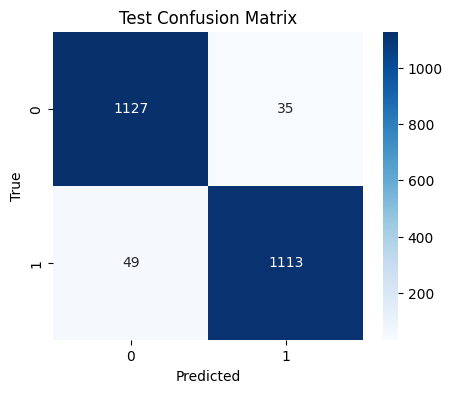

In [ ]:
#Evaluation
evaluate_model(test_ds, split_name="Test")